## Introduction

In this notebook, I am trying to implement what the author of paper [DiffEdit](https://arxiv.org/pdf/2210.11427.pdf) proposed - 

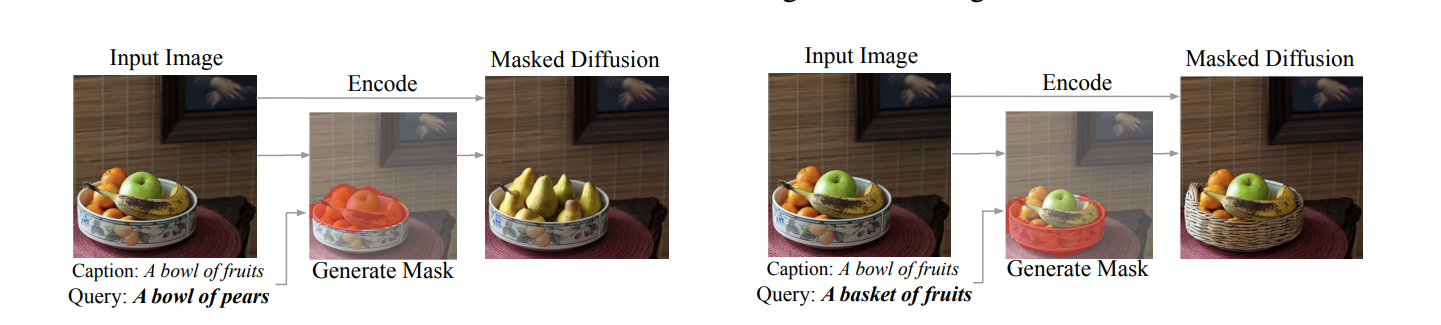

## Importing libraries

In [59]:
import torch, logging
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler, DDIMScheduler
from diffusers import StableDiffusionImg2ImgPipeline
import PIL
from PIL import Image
from pathlib import Path
from fastdownload import FastDownload
from torchvision import transforms as tfms
import numpy as np

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
logging.disable(logging.WARNING) ## ignore warnings
%matplotlib inline

## Pre loading models

Stable diffusion model depends on three things - 
1. `CLIP model` - For converting promts to a embedding which gives the visual clue
2. `VAE (Variational Auto Encoder)` - To reduce the dimensions of the original image for faster computations
3. `UNET` - The model which takes a noisy i/p and embedded promt to predict the noise present in the i/p

### Importing diffusion UNet and VAE

In [2]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

### CLIP artifacts

In this case, we are using CLIP model which converts the texual prompt into an embedding. To do this using transformers library ,we need two things - 
- 1) `Tokenizer` - This function takes the raw text, breaks it into words and then convert them into numeric forms
- 2) `text_encoder` - This function takes the tokenizer ip and convert them into embeddings

In [3]:
## Loading clip tokenizer and encoder 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

### Scheduler Artifacts

This tells the model on how much noise to add at a given timestep

In [4]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [62]:
scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

## Simple text to image inference

In [63]:
def load_image(p):
    return Image.open(p).convert('RGB').resize((512,512))

def latents_to_pil(latents):
    return vae.decode(1 / 0.18215 * latents).sample

def preprocess(image):
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def preprocess(image):
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    """
    A function to take the sample and convert it back into the original image
    """
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

## What does DiffEdit do? 

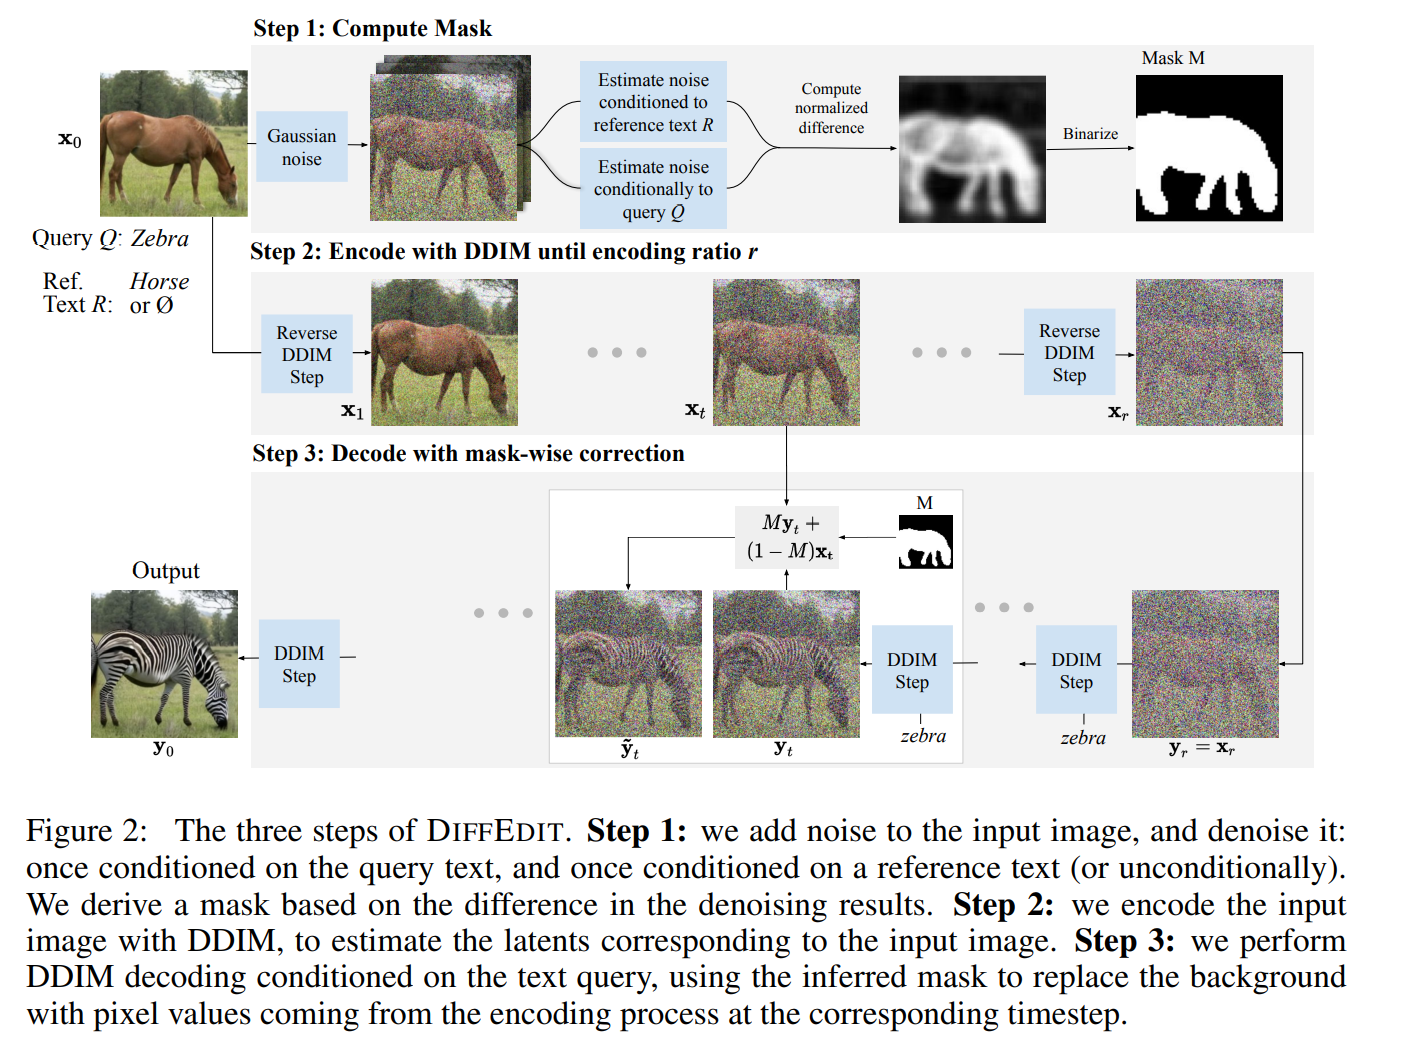

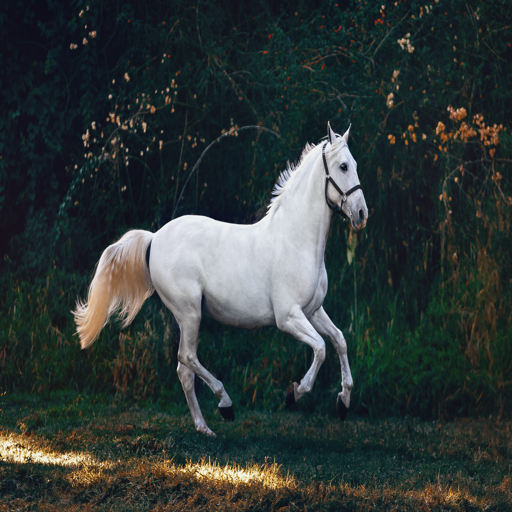

In [6]:
p = FastDownload().download('https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg?cs=srgb&dl=pexels-helena-lopes-1996333.jpg&fm=jpg&_gl=1*1pc0nw8*_ga*OTk4MTI0MzE4LjE2NjY1NDQwMjE.*_ga_8JE65Q40S6*MTY2Njc1MjIwMC4yLjEuMTY2Njc1MjIwMS4wLjAuMA..')

load_image(p)

###  Step 1: we add noise to the input image, and denoise it:
once conditioned on the query text, and once conditioned on a reference text (or unconditionally).
We derive a mask based on the difference in the denoising results

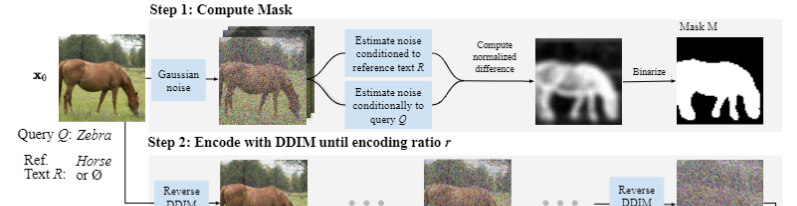

Step 1: Computing editing mask. When the denoising an image, a text-conditioned diffusion
model will yield different noise estimates given different text conditionings. We can consider where
the estimates are different, which gives information about what image regions are concerned by
the change in conditioning text. For instance, in Figure 2, the noise estimates conditioned to the
query zebra and reference text horse1 are different on the body of the animal, where they will tend
to decode different colors and textures depending on the conditioning. For the background, on the
other hand, there is little change in the noise estimates. The difference between the noise estimates
can thus be used to infer a mask that identifies what parts on the image need to be changed to
match the query. In our algorithm, we use a Gaussian noise with strength 50% (see analysis in
Appendix A.1), remove extreme values in noise predictions and stabilize the effect by averaging
spatial differences over a set of n input noises, with n=10 in our default configuration. The result is
then rescaled to the range [0,1], and binarized with a threshold, which we set to 0.5 by default. 

In [64]:
steps = 50
g = 7.5
strength = 0.5
scheduler.set_timesteps(steps)
init_image = load_image(p)

In [124]:
def get_noisy_pred(prompt, init_img, neg_prompt=None, g=7.5, strength =0.5, seed=100, steps=50, dim=512):
    text = text_enc(prompt)
    uncond =  text_enc([""], text.shape[1])
    emb = torch.cat([uncond, text])
    init_latents = preprocess(init_img)
    
    init_timestep = int(steps * strength)
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timesteps)
    with torch.no_grad():
        u,t = unet(latent_model_input, timesteps, encoder_hidden_states=emb).sample.chunk(2)

    pred = u + g*(t - u)
    
    return scheduler.step(pred, timesteps, latents).pred_original_sample

In [125]:
n = 20
diff = {}
for i in range(n):
    print(i)
    orig_noisy = get_noisy_pred(prompt= ["a horse image"], init_img=load_image(p))
    target_noisy = get_noisy_pred(prompt= ["a zebra image"], init_img=load_image(p))
    diff[i] = latents_to_pil(orig_noisy-target_noisy)[0].detach().cpu()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [140]:
mask = torch.zeros_like(diff[0], dtype = diff[0].dtype)
for i in range(n):
    mask += diff[i]
mask = mask / n

mask = (mask - mask.min()) / (mask.max()-mask.min()) >= 0.5

mask  = np.round((mask.permute(1, 2, 0).numpy()))

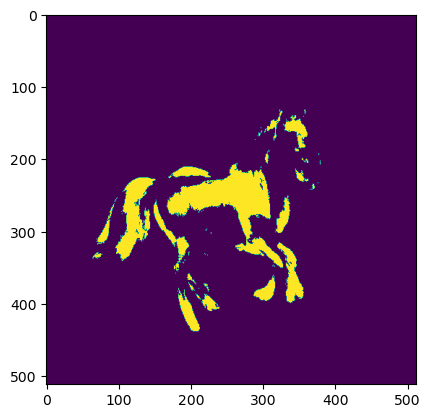

In [141]:
plt.imshow((mask.mean(axis=-1)).astype("uint8"))